In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

import mbrl.mbpo as mbpo
import mbrl.replay_buffer as replay_buffer

device = torch.device("cuda:0")


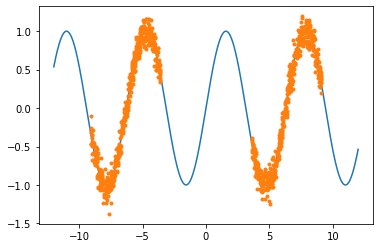

In [3]:
x_data = np.linspace(-12, 12, 10000)
y_data = np.sin(x_data)

train_size = 1000
train_idx = np.random.choice(list(range(1200, 3500)) + list(range(6500, 8800)), size=train_size, replace=False)
x_train = x_data[train_idx]
y_train = y_data[train_idx] + 0.1 * np.random.randn(train_size)

plt.plot(x_data, y_data, x_train, y_train, '.')
plt.show()

In [4]:
dataset = replay_buffer.BootstrapReplayBuffer(train_size, 256, num_members, (1,), (0,))

In [5]:
for i in range(train_size):
    dataset.add(x_train[i], 0, y_train[i], 0, False)

In [ ]:
num_members = 5
ensemble = [mbpo.GaussianMLP(1, 1, 2, 10).to(device) for _ in range(num_members)]
optimizers = [optim.Adam(ensemble[i].parameters(), lr=0.01) for i in range(num_members)]

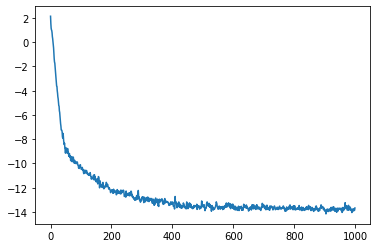

In [13]:
losses = mbpo.train_dyn_model(ensemble, optimizers, dataset, 1000, device)
plt.plot(losses)
plt.show()

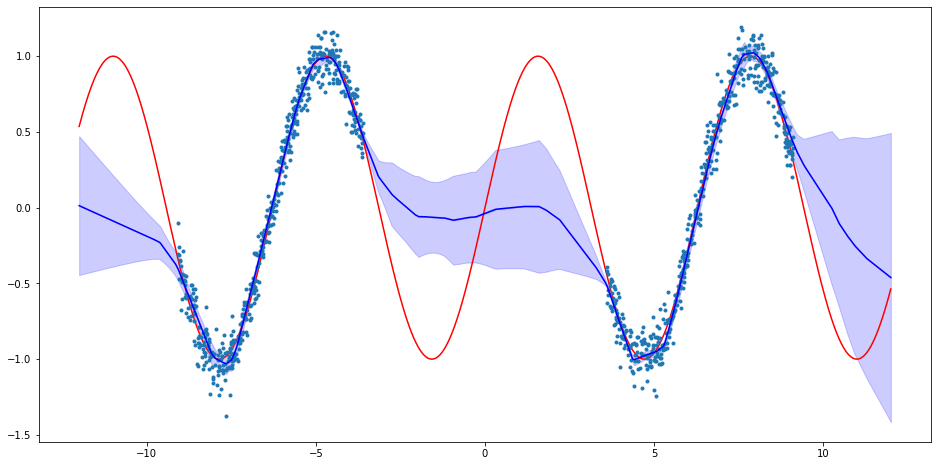

In [14]:
x_tensor = torch.from_numpy(x_data).unsqueeze(1).float().to(device)

y_mean = np.zeros_like(y_data)
for i in range(num_members):
    net = ensemble[i]
    pred = net(x_tensor)
    y_pred = pred[0].squeeze().detach().cpu().numpy()
    y_mean += y_pred
y_mean /= num_members

y_std = np.zeros_like(y_data)
for i in range(num_members):
    net = ensemble[i]
    pred = net(x_tensor)
    y_pred = pred[0].squeeze().detach().cpu().numpy()
    y_std += (y_pred - y_mean) ** 2
y_std /= (num_members - 1)
y_std = np.sqrt(y_std)
    
plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, 'r', x_train, y_train, '.', x_data, y_mean, 'b')
plt.fill_between(x_data, y_mean, y_mean + y_std, color='b', alpha=0.2)
plt.fill_between(x_data, y_mean - y_std, y_mean, color='b', alpha=0.2)
plt.show()